In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms

#load mnist dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())
mnist_images = mnist_trainset.data.numpy()[:50].reshape(-1,28*28)
mnist_labels = mnist_trainset.targets.numpy()[:50].reshape(-1)
mnist_images = mnist_images/255



class SVM:
    def __init__(self,X,Y,C=1,kernel='linear',epsilon = 1e-5,sigma =1,d=2):
        self.C = C
        self.d = d
        self.kernel = kernel
        self.epsilon = epsilon
        self.alpha = np.zeros(len(X))
        self.b = 0
        self.sigma = sigma
        self.K = np.zeros((len(X),len(X)))
        for i in range(len(X)):
            for j in range(len(X)):
                self.K[i,j] = self.Kernel(X[i],X[j])
        self.Ei_list = None
        self.gxi_list = None
        self.X = X
        self.Y = Y
        self.H = None
        self.L = None
        self.length = len(X)

    def pick_first(self):
        con1 = self.alpha > 0
        con2 = self.alpha < self.C
        err1 = self.Y*self.gxi_list -1
        err2 = err1.copy()
        err3 = err1.copy()
        err1[(con1 & ( err1 <= 0 )) | (~con1&(err1 >= 0))] = 0
        err2[((~con1 | ~con2) & (err2 != 0)) | (con1 & con2) & (err2 == 0)] = 0
        err3[(con2 & (err3 >= 0)) | (~con2 & (err3 <= 0))] = 0
        err = err1**2 + err2**2 + err3**2
        idx = np.argmax(err)
        if err[idx] == 0:
            return -1
        return idx 

    def pick_second(self,idx_1):
        idx_2 = -1
        max_delta = -1
        for i in range(self.length):
            if i == idx_1:
                continue
            delta = abs(self.Ei_list[idx_1]-self.Ei_list[i])
            if delta > max_delta:
                max_delta = delta
                idx_2 = i
        return idx_2

    def set_bound(self,idx_1,idx_2):
        if self.Y[idx_1] == self.Y[idx_2]:
            self.L = max(0,self.alpha[idx_1]+self.alpha[idx_2]-self.C)
            self.H = min(self.C,self.alpha[idx_1]+self.alpha[idx_2])
        else:
            self.L = max(0,self.alpha[idx_2]-self.alpha[idx_1])
            self.H = min(self.C,self.C+self.alpha[idx_2]-self.alpha[idx_1])

    def update(self,idx_1,idx_2):
        alpha_1_old = self.alpha[idx_1]
        alpha_2_old = self.alpha[idx_2]
        y_1 = self.Y[idx_1]
        y_2 = self.Y[idx_2]
        self.set_bound(idx_1,idx_2)
        eta = self.K[idx_1,idx_1]+self.K[idx_2,idx_2]-2*self.K[idx_1,idx_2]
        alpha_2_new = alpha_2_old+y_2*(self.Ei_list[idx_1]-self.Ei_list[idx_2])/eta
        alpha_2_new = self.truncate(alpha_2_new)
        alpha_1_new = alpha_1_old+y_1*y_2*(alpha_2_old-alpha_2_new)
        b_1_new = -self.Ei_list[idx_1]-y_1*self.K[idx_1,idx_1]*(alpha_1_new-alpha_1_old)-y_2*self.K[idx_2,idx_1]*(alpha_2_new-alpha_2_old)+self.b
        b_2_new = -self.Ei_list[idx_2]-y_1*self.K[idx_1,idx_2]*(alpha_1_new-alpha_1_old)-y_2*self.K[idx_2,idx_2]*(alpha_2_new-alpha_2_old)+self.b
        if alpha_1_new > 0 and alpha_1_new < self.C:
            b_new = b_1_new
        elif alpha_2_new > 0 and alpha_2_new < self.C:
            b_new = b_2_new
        else:
            b_new = (b_1_new+b_2_new)/2
        self.alpha[idx_1] = alpha_1_new
        self.alpha[idx_2] = alpha_2_new
        self.b = b_new

    def fit(self):
        iter = 0
        while iter < 10000:
            self.gxi_list = [np.dot(self.alpha*self.Y,self.K[i])+self.b for i in range(self.length)]
            self.Ei_list = [self.gxi_list[i]-self.Y[i] for i in range(self.length)]
            idx_1 = self.pick_first()
            if idx_1 == -1:
                break
            idx_2 = self.pick_second(idx_1)
            self.update(idx_1,idx_2)
            iter += 1
        #find a alpha that is not 0 and not C
        for i in range(self.length):
            if self.alpha[i] != 0 and self.alpha[i] != self.C:
                break
        self.b = self.Y[i]-np.dot(self.alpha*self.Y,self.K[i])
        
        return self.alpha,self.b

    def predict(self,X):
        gxi = self.b
        for i in range(self.length):
            a = self.Kernel(self.X[i],X)
            b = a*self.alpha[i]
            c = b*self.Y[i]
            gxi += c
        return np.sign(gxi)
    
    def Kernel(self,x1,x2):
        if self.kernel == "linear":
            return np.dot(x1,x2.T)
        elif self.kernel == "poly":
            return (np.dot(x1,x2.T)+1)**self.d
        elif self.kernel == "rbf":
            return np.exp(-np.sum((x1-x2)**2)/(2*self.sigma**2))

    def score(self,X,Y):
        pred = self.predict(X)
        return np.sum(pred == Y)/len(Y)

    def truncate(self,alpha):
        if alpha > self.C:
            alpha = self.C
        elif alpha < 0:
            alpha = 0
        return alpha
    

class MultiSVM:
    def __init__(self,X,Y,class_num=10,kernel="linear",C = 10,epsilon=1e-5):
        self.C = C
        self.class_num = class_num
        self.kernel = kernel
        self.epsilon = epsilon
        self.SVM_list = []
        self.method = "ovo"
        self.X = X
        self.Y = Y
        self.length = len(X)

    def fit(self):
        for i in range(self.class_num):
            for j in tqdm(range(i+1,self.class_num)):
                idx = (self.Y == i) | (self.Y == j)
                X = self.X[idx]
                Y = self.Y[idx]
                Y[Y == i] = -1
                Y[Y == j] = 1
                svm = SVM(X,Y,C=self.C,kernel=self.kernel,epsilon=self.epsilon)
                alpha,b = svm.fit()
                self.SVM_list.append((svm,i,j))

    
    def predict(self,X):
        pred = np.zeros(self.class_num)
        for svm,i,j in self.SVM_list:
            if svm.predict(X) == -1:
                pred[i] += 1
            else:
                pred[j] += 1

        num = np.argmax(pred)
        return num
        
    def score(self,X,Y):
        pred = []
        for x in tqdm(X):
            pred.append(self.predict(x))
        pred = np.array(pred)
        return np.sum(pred == Y)/len(Y)

In [19]:
MultiSVM_model = MultiSVM(mnist_images,mnist_labels,kernel="linear")
MultiSVM_model.fit()

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
0it [00:00, ?it/s]


100%|██████████| 40/40 [00:00<00:00, 55.88it/s]


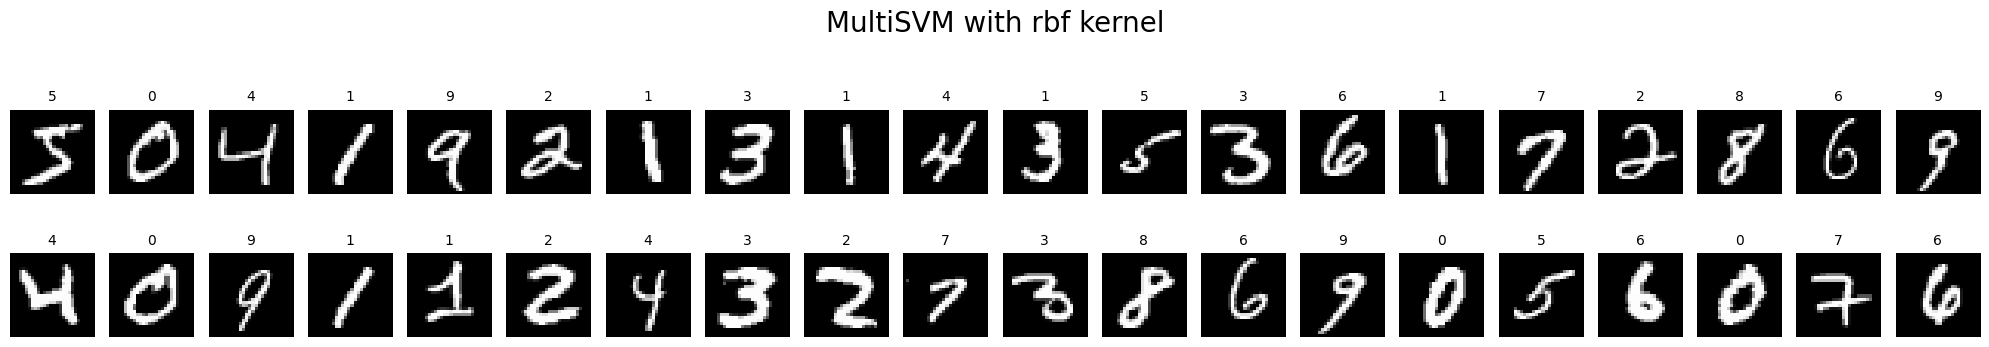

In [20]:
# mnist_images_test = mnist_testset.data.numpy().reshape(-1,28*28)[:40]/255
# mnist_labels_test = mnist_testset.targets.numpy()[:40]
plt.figure(figsize=(20,4))
for i in tqdm(range(40)):
    plt.subplot(2,20,i+1)
    plt.imshow(mnist_images[i].reshape(28,28),cmap="gray")
    plt.title(MultiSVM_model.predict(mnist_images[i]),fontsize= 10)
    plt.axis("off")
plt.suptitle("MultiSVM with rbf kernel",fontsize=20)
plt.tight_layout()
plt.show()

In [21]:
mnist_images_test = mnist_testset.data.numpy().reshape(-1,28*28)[:500]/255
mnist_labels_test = mnist_testset.targets.numpy()[:500]
print(MultiSVM_model.score(mnist_images_test,mnist_labels_test))

100%|██████████| 500/500 [00:00<00:00, 938.36it/s]

0.578


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms

#load mnist dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())
mnist_images = mnist_trainset.data.numpy()[:250].reshape(-1,28*28)
mnist_labels = mnist_trainset.targets.numpy()[:250].reshape(-1)
mnist_images = mnist_images/255



class SVM:
    def __init__(self,X,Y,Y_ref,C=1,kernel='linear',epsilon = 1e-5,sigma =1,d=2):
        self.C = C
        self.d = d
        self.Y_ref = Y_ref
        self.kernel = kernel
        self.epsilon = epsilon
        self.alpha = np.zeros(len(X))
        self.b = 0
        self.sigma = sigma
        self.K = np.zeros((len(X),len(X)))
        for i in range(len(X)):
            for j in range(len(X)):
                self.K[i,j] = self.Kernel(X[i],X[j])
        self.Ei_list = None
        self.gxi_list = None
        self.X = X
        self.Y = Y
        self.H = None
        self.L = None
        self.length = len(X)

    def pick_first(self):
        con1 = self.alpha > 0
        con2 = self.alpha < self.C
        err1 = self.Y*self.gxi_list -1
        err2 = err1.copy()
        err3 = err1.copy()
        err1[(con1 & ( err1 <= 0 )) | (~con1&(err1 >= 0))] = 0
        err2[((~con1 | ~con2) & (err2 != 0)) | (con1 & con2) & (err2 == 0)] = 0
        err3[(con2 & (err3 >= 0)) | (~con2 & (err3 <= 0))] = 0
        err = err1**2 + err2**2 + err3**2
        idx = np.argmax(err)
        if err[idx] == 0:
            return -1
        return idx 

    def pick_second(self,idx_1):
        idx_2 = -1
        max_delta = -1
        for i in range(self.length):
            if i == idx_1:
                continue
            delta = abs(self.Ei_list[idx_1]-self.Ei_list[i])
            if delta > max_delta:
                max_delta = delta
                idx_2 = i
        return idx_2

    def set_bound(self,idx_1,idx_2):
        if self.Y[idx_1] == self.Y[idx_2]:
            self.L = max(0,self.alpha[idx_1]+self.alpha[idx_2]-self.C)
            self.H = min(self.C,self.alpha[idx_1]+self.alpha[idx_2])
        else:
            self.L = max(0,self.alpha[idx_2]-self.alpha[idx_1])
            self.H = min(self.C,self.C+self.alpha[idx_2]-self.alpha[idx_1])

    def update(self,idx_1,idx_2):
        alpha_1_old = self.alpha[idx_1]
        alpha_2_old = self.alpha[idx_2]
        y_1 = self.Y_ref[idx_1]
        y_2 = self.Y_ref[idx_2]
        self.set_bound(idx_1,idx_2)
        eta = self.K[idx_1,idx_1]+self.K[idx_2,idx_2]-2*self.K[idx_1,idx_2]
        alpha_2_new = alpha_2_old+y_2*(self.Ei_list[idx_1]-self.Ei_list[idx_2])/eta
        alpha_2_new = self.truncate(alpha_2_new)
        alpha_1_new = alpha_1_old+y_1*y_2*(alpha_2_old-alpha_2_new)
        b_1_new = -self.Ei_list[idx_1]-y_1*self.K[idx_1,idx_1]*(alpha_1_new-alpha_1_old)-y_2*self.K[idx_2,idx_1]*(alpha_2_new-alpha_2_old)+self.b
        b_2_new = -self.Ei_list[idx_2]-y_1*self.K[idx_1,idx_2]*(alpha_1_new-alpha_1_old)-y_2*self.K[idx_2,idx_2]*(alpha_2_new-alpha_2_old)+self.b
        if alpha_1_new > 0 and alpha_1_new < self.C:
            b_new = b_1_new
        elif alpha_2_new > 0 and alpha_2_new < self.C:
            b_new = b_2_new
        else:
            b_new = (b_1_new+b_2_new)/2
        self.alpha[idx_1] = alpha_1_new
        self.alpha[idx_2] = alpha_2_new
        self.b = b_new

    def fit(self):
        iter = 0
        while iter < 10000:
            # for i in range(self.length):
                # a = self.alpha*self.Y_ref
                # b = np.dot(a,self.K[i])
                # c = b+self.b
                # self.gxi_list[i] = c
                # self.Ei_list[i] = self.gxi_list[i]-self.Y_ref[i]
            self.gxi_list = [np.dot(self.alpha*self.Y_ref,self.K[i])+self.b for i in range(self.length)]
            self.Ei_list = [self.gxi_list[i]-self.Y_ref[i] for i in range(self.length)]
            idx_1 = self.pick_first()
            if idx_1 == -1:
                break
            idx_2 = self.pick_second(idx_1)
            self.update(idx_1,idx_2)
            iter += 1
        #find a alpha that is not 0 and not C
        for i in range(self.length):
            if self.alpha[i] != 0 and self.alpha[i] != self.C:
                break
        self.b = self.Y_ref[i]-np.dot(self.alpha*self.Y_ref,self.K[i])
        
        return self.alpha,self.b

    def predict(self,X):
        gxi = self.b
        for i in range(self.length):
            a = self.Kernel(self.X[i],X)
            b = a*self.alpha[i]
            c = b*self.Y[i]
            gxi += c
        return np.sign(gxi)
    
    def Kernel(self,x1,x2):
        if self.kernel == "linear":
            return np.dot(x1,x2.T)
        elif self.kernel == "poly":
            return (np.dot(x1,x2.T)+1)**self.d
        elif self.kernel == "rbf":
            return np.exp(-np.sum((x1-x2)**2)/(2*self.sigma**2))

    def score(self,X,Y):
        pred = self.predict(X)
        return np.sum(pred == Y)/len(Y)

    def truncate(self,alpha):
        if alpha > self.C:
            alpha = self.C
        elif alpha < 0:
            alpha = 0
        return alpha
    

class MultiSVM:
    def __init__(self,X,Y,weight,class_num=10,kernel="linear",C = 10,epsilon=1e-5):
        self.C = C
        self.class_num = class_num
        self.kernel = kernel
        self.epsilon = epsilon
        self.SVM_list = []
        self.method = "ovo"
        self.X = X
        self.Y = Y
        self.weight = weight
        self.length = len(X)

    def fit(self):
        for i in range(self.class_num):
            for j in tqdm(range(i+1,self.class_num)):
                idx = (self.Y == i) | (self.Y == j)
                X = self.X[idx]
                Y = self.Y[idx]
                Y[Y == i] = -1
                Y[Y == j] = 1
                Weight = self.weight[idx]
                Y_ref = Y*Weight
                svm = SVM(X,Y,Y_ref,C=self.C,kernel=self.kernel,epsilon=self.epsilon)
                alpha,b = svm.fit()
                self.SVM_list.append((svm,i,j))

    
    def predict(self,X):
        pred = np.zeros(self.class_num)
        for svm,i,j in self.SVM_list:
            if svm.predict(X) == -1:
                pred[i] += 1
            else:
                pred[j] += 1

        num = np.argmax(pred)
        return num
        
    def score(self,X,Y):
        pred = []
        for x in tqdm(X):
            pred.append(self.predict(x))
        pred = np.array(pred)
        return np.sum(pred == Y)/len(Y)
    

class AdaBoost_MultiSVM:
    def __init__(self,X,Y,C=1,kernel="linear",epsilon=1e-5,class_num=10,max_iter=10,d=2,sigma=1):
        self.C = C
        self.kernel = kernel
        self.epsilon = epsilon
        self.class_num = class_num
        self.max_iter = max_iter
        self.d = d
        self.sigma = sigma
        self.X = X
        self.Y = Y
        self.length = len(X)
        self.alpha_list = []
        self.b_list = []
        self.method = "ovo"
        self.classifier_weight = []
        self.classifier_list = []
        self.sample_weight = np.ones(self.length)

    def fit(self):
        for i in range(self.max_iter):
            MultiSVM_model = MultiSVM(self.X,self.Y,self.sample_weight,class_num=self.class_num,kernel=self.kernel,C=self.C,epsilon=self.epsilon)
            MultiSVM_model.fit()
            pred = []
            for x in tqdm(self.X):
                pred.append(MultiSVM_model.predict(x))
            pred = np.array(pred)
            error = np.sum(pred != self.Y)/self.length
            print("error rate: {}".format(error))
            # if error > 0.5:
                # break
            alpha = 0.5*np.log((1-error)/error)
            self.alpha_list.append(alpha)
            self.classifier_weight.append(alpha)
            self.classifier_list.append(MultiSVM_model)
            self.sample_weight = self.sample_weight*np.exp(-alpha*self.Y*pred)
            self.sample_weight = self.sample_weight/np.sum(self.sample_weight)
            score = self.score(self.X,self.Y)
            print("iter: {},train score: {}".format(i,score))

    def predict(self,X):
        pred = np.zeros(self.class_num)
        for alpha,classifier in zip(self.alpha_list,self.classifier_list):
            pred[classifier.predict(X)] += alpha
        return np.argmax(pred)
    
    def score(self,X,Y):
        pred = []
        for x in tqdm(X):
            pred.append(self.predict(x))
        pred = np.array(pred)
        return np.sum(pred == Y)/len(Y)
            




In [25]:
AdaBoost_MultiSVM_model = AdaBoost_MultiSVM(mnist_images,mnist_labels,kernel="linear",max_iter=10)
AdaBoost_MultiSVM_model.fit()

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
0it [00:00, ?it/s]
100%|██████████| 250/250 [00:01<00:00, 174.85it/s]


error rate: 0.024


100%|██████████| 250/250 [00:01<00:00, 172.24it/s]


iter: 0,train score: 0.976


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]
0it [00:00, ?it/s]
100%|██████████| 250/250 [00:01<00:00, 167.38it/s]


error rate: 0.88


100%|██████████| 250/250 [00:02<00:00, 85.73it/s]


iter: 1,train score: 0.976


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]
0it [00:00, ?it/s]
100%|██████████| 250/250 [00:01<00:00, 178.96it/s]


error rate: 0.88


100%|██████████| 250/250 [00:04<00:00, 59.52it/s]


iter: 2,train score: 0.868


 88%|████████▊ | 7/8 [00:14<00:02,  2.11s/it]


KeyboardInterrupt: 

MultiSVM_model = MultiSVM(mnist_images,mnist_labels)
MultiSVM_model.fit()
plt.figure(figsize = (10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(mnist_images[i].reshape(28,28),)
    plt.axis("off")
    plt.title(MultiSVM_model.predict(i))
plt.show()